# Faire une régression en forçant les valeurs à être entière sur la demande

Importer le modèle de régression

In [2]:
import sys, os

import pyomo.environ as pyo
solver = 'ipopt'
SOLVER = pyo.SolverFactory(solver)
assert SOLVER.available(), f"Solver {solver} is not available."

solver_LO = 'glpk'
SOLVER_LO = pyo.SolverFactory(solver_LO)
assert SOLVER_LO.available(), f"Solver {solver_LO} is not available."

Définir la fonction de régression

In [3]:
def ols_regression(X, y):
    model = pyo.ConcreteModel("OLS Regression")

    n, k = X.shape

    # note use of Python style zero based indexing
    model.I = pyo.RangeSet(0, n - 1)
    model.J = pyo.RangeSet(0, k - 1)

    model.e = pyo.Var(model.I, domain=pyo.Reals)
    model.m = pyo.Var(model.J)
    model.b = pyo.Var()

    @model.Constraint(model.I)
    def residuals(m, i):
        return m.e[i] == y[i] - sum(X[i][j] * m.m[j] for j in m.J) - m.b
    
    # @model.Constraint()
    # def rounding_constraint(m):
    #     return sum(m.m[j] for j in m.J) >= 1  # Example constraint to force non-trivial solution

    @model.Objective(sense=pyo.minimize)
    def sum_of_square_errors(m):
        return sum((m.e[i]) ** 2 for i in m.I)

    return model

In [4]:
def lad_regression(X, y):
    model = pyo.ConcreteModel("LAD Regression")

    # get dimensions of data
    n, k = X.shape

    # create index sets (note use of Python style zero based indexing)
    model.I = pyo.RangeSet(0, n - 1)
    model.J = pyo.RangeSet(0, k - 1)

    # create variables
    model.ep = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.em = pyo.Var(model.I, domain=pyo.NonNegativeReals)
    model.m = pyo.Var(model.J)
    model.b = pyo.Var()

    # constraints
    @model.Constraint(model.I)
    def residuals(m, i):
        return m.ep[i] - m.em[i] == y[i] - sum(X[i][j] * m.m[j] for j in m.J) - m.b

    # objective
    @model.Objective(sense=pyo.minimize)
    def sum_of_abs_errors(m):
        return sum(m.ep[i] + m.em[i] for i in m.I)

    return model

Définir les données sur laquelle on va faire la régression

In [5]:
import pandas as pd
import numpy as np

df_comp_details = pd.read_csv('duopoly_competition_details.csv')
df_comp_details.fillna(0, inplace=True)

df_comp_details['revenue'] = df_comp_details['price'] * df_comp_details['demand']

df_comp_details.head(3)

,competition_id,selling_season,selling_period,competitor_id,price_competitor,price,demand,competitor_has_capacity,calculation_duration,errors,revenue
0,3fDw3f,1,1,ZealousMosquito,46.6,48.0,2,True,0.0,0.0,96.0
1,3fDw3f,1,2,ZealousMosquito,46.4,57.6,0,True,0.0,0.0,0.0
2,3fDw3f,1,3,ZealousMosquito,66.9,69.1,1,True,0.0,0.0,69.1


In [6]:
df_comp_details['unique_selling_season_key'] = df_comp_details.apply(lambda r:
                                "%s_%s" % (r.competition_id,r.selling_season), axis=1)

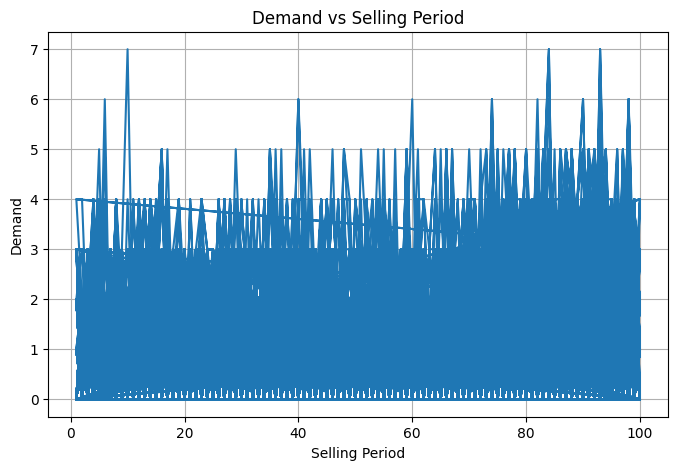

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(df_comp_details["selling_period"], df_comp_details["demand"])
plt.xlabel("Selling Period")
plt.ylabel("Demand")
plt.title("Demand vs Selling Period")
plt.grid(True)
plt.show()

3fDw3f


<Axes: >

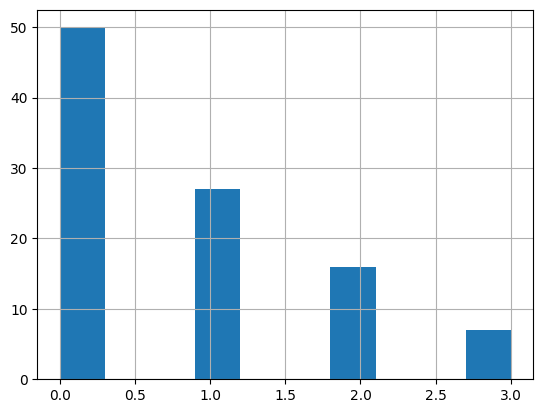

In [12]:
comp = df_comp_details.competition_id.unique()[0]
print(comp)

# filter on first competion_id
df = df_comp_details[df_comp_details.competition_id==comp ]

# concentrate on selling period in [1,20]
# df = df[df.selling_period <= 20 ]
# df = df[df.selling_period <= 20 & df.selling_period <= 40 ]
# df = df[df.selling_period <= 40 & df.selling_period <= 60 ]
# df = df[df.selling_period <= 60 & df.selling_period <= 80 ]
# df = df[(df.selling_period > 80) & (df.selling_period <= 100)]

df_train = df[df.selling_season==1]
df_test = df[df.selling_season>1]

df_train.demand.hist()



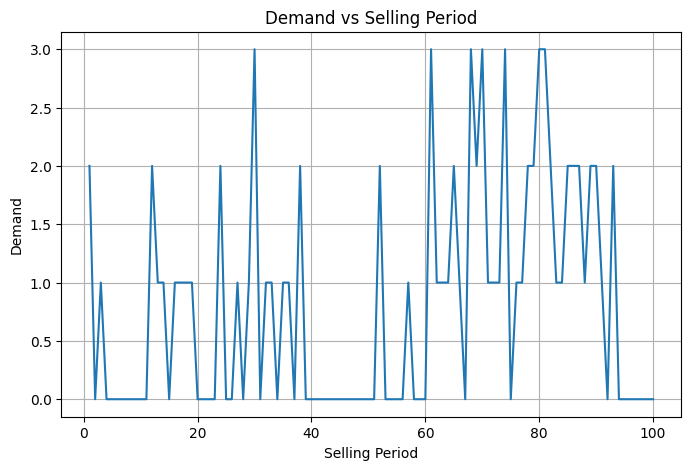

In [13]:
plt.figure(figsize=(8, 5))
plt.plot(df_train["selling_period"], df_train["demand"])
plt.xlabel("Selling Period")
plt.ylabel("Demand")
plt.title("Demand vs Selling Period")
plt.grid(True)
plt.show()

In [31]:
y = df_train.demand
X = df_train[['price', 'price_competitor']]
X = X.to_numpy()
print(X)

[[48.  46.6]
 [57.6 46.4]
 [69.1 66.9]
 [82.9 45.4]
 [94.  45. ]
 [97.2 47.7]
 [97.3 54. ]
 [93.  57.5]
 [85.7 52.7]
 [77.  47.9]
 [68.  44.2]
 [59.  62.8]
 [55.7 68.8]
 [54.  58.5]
 [53.  66.3]
 [50.8 52.2]
 [49.5 56. ]
 [49.1 47.6]
 [49.6 63.9]
 [50.9 58.8]
 [51.6 41.2]
 [51.5 41. ]
 [50.8 42.1]
 [49.1 64.3]
 [49.3 65.9]
 [49.  54.7]
 [48.1 64.5]
 [47.6 50. ]
 [46.6 68.8]
 [46.  67.1]
 [47.4 40.4]
 [48.6 55.7]
 [50.1 51.6]
 [52.1 60.8]
 [53.6 60.4]
 [55.5 60.3]
 [57.9 43.5]
 [59.9 59.9]
 [63.2 58.9]
 [66.4 42.5]
 [69.1 67.2]
 [71.3 63.2]
 [73.1 47.7]
 [74.4 50.9]
 [75.2 45.1]
 [75.5 60.4]
 [75.3 48.6]
 [74.8 55. ]
 [74.  50.1]
 [72.6 48. ]
 [70.7 57. ]
 [68.5 63.7]
 [67.3 46.2]
 [65.5 54.7]
 [63.3 65.5]
 [60.7 50.4]
 [58.  57.8]
 [55.6 49. ]
 [53.1 49.5]
 [50.3 59.1]
 [47.4 59. ]
 [45.6 44.7]
 [44.  42. ]
 [42.4 66.2]
 [40.9 59.2]
 [39.8 48. ]
 [38.7 44.7]
 [37.3 59.6]
 [36.5 41.1]
 [35.9 57.2]
 [35.9 47.9]
 [35.9 58.1]
 [35.7 62.9]
 [35.5 65.7]
 [35.6 66.4]
 [35.4 43.1]
 [35.2 43.1]

In [32]:
model = lad_regression(X, y)
SOLVER.solve(model)
model.m.display()
model.b.display()

m : Size=2, Index=J
    Key : Lower : Value                 : Upper : Fixed : Stale : Domain
      0 :  None : -0.028805673414537443 :  None : False : False :  Reals
      1 :  None :   0.01994238716423737 :  None : False : False :  Reals
b : Size=1, Index=None
    Key  : Lower : Value              : Upper : Fixed : Stale : Domain
    None :  None : 1.1544428600515102 :  None : False : False :  Reals


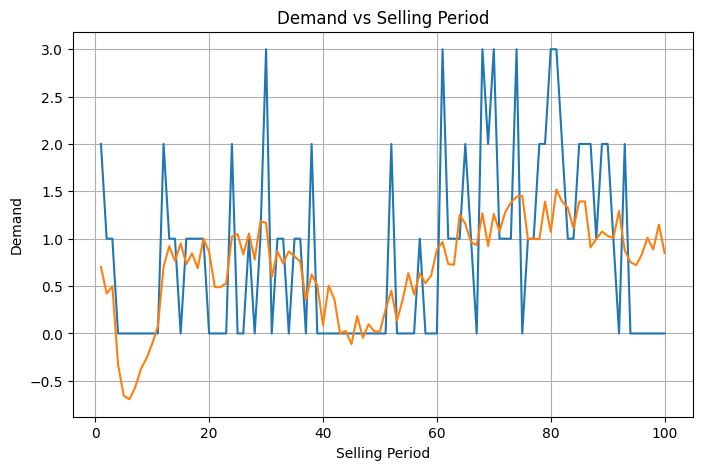

In [33]:
y_fit = np.array([sum(x[j] * model.m[j]() for j in model.J) + model.b() for x in X])
plt.figure(figsize=(8, 5))
plt.plot(df_train["selling_period"], df_train["demand"])
plt.plot(df_train["selling_period"], y_fit)
plt.xlabel("Selling Period")
plt.ylabel("Demand")
plt.title("Demand vs Selling Period")
plt.grid(True)
plt.show()
